# Figure 3

Supplemental figures will confirm that this is not fundamentally different from gradual drift in all features simultaneousl. 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import multiprocess as multi
try:
    multi.set_start_method('spawn')
except RuntimeError:
    print('couldn\'t set context')
import master
from master   import *
from parallel import _parmap, helper, try_variations
limit_cores()
debug = True
master.PRINT_LOGGING = not debug

Shuffling job sequence
Parallel using 20 cores
Preparing to run 5 jobs
Starting...
[████████████████████████████████████████]100.200% 

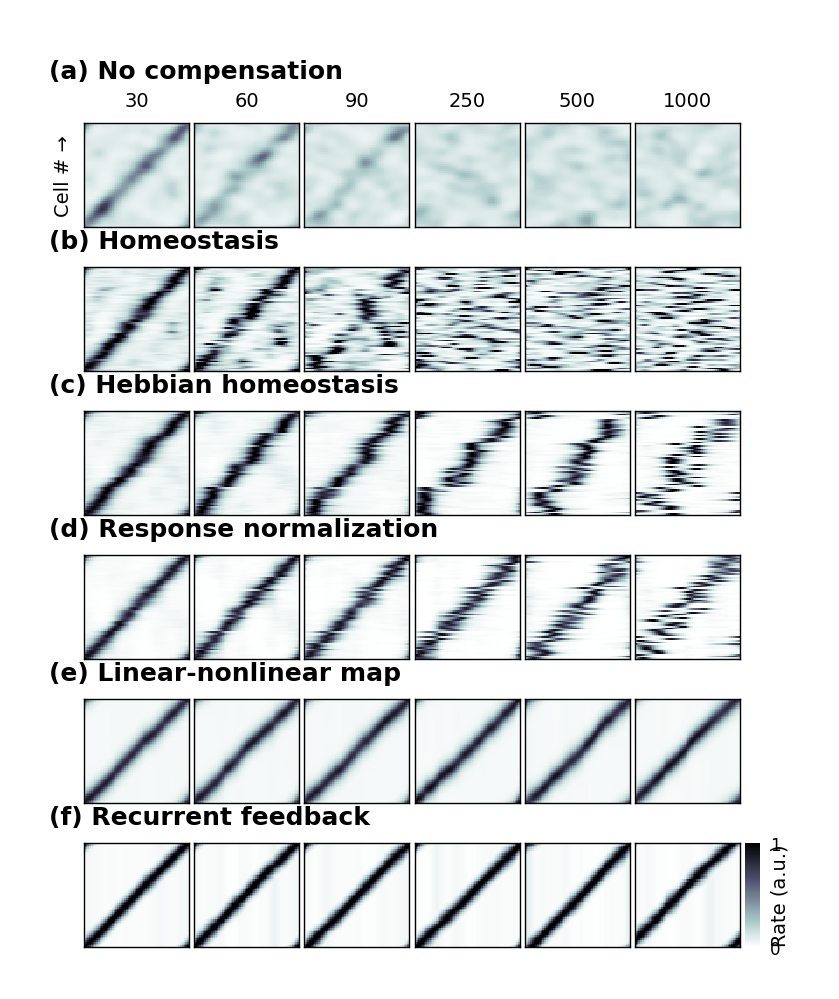

In [2]:
ishow = int32([30, 60, 90, 250, 500, 1000])

def do_f4( opts ):
    opts = {**opts,'saveall':True}
    jobs = [{**opts,'method':'homeostat' ,'normalize':False,**homeostat_rates},
            {**opts,'method':'hebbhomeo' ,'normalize':False,**hebb_rates     },
            {**opts,'method':'hebbhomeo' ,'normalize':True ,**hebb_rates     },
            {**opts,'method':'recurrent' ,'normalize':True ,**map_rates      },
            {**opts,'method':'predictive','normalize':True ,**feedback_rates }]
    results = _parmap(helper,jobs,debug=debug)
    pop_homeostat, pop_hebbhomeo, pop_normalize, pop_recurrent, pop_predictive = results

    # Simulate fixed readout and collect all results
    W0,X,Y0,Y,W,R,G,B = pop_recurrent
    Δ,T,K  = opts['Δ'],opts['T'],opts['K']
    tsaved = arange(Δ-1,(shape(W)[0]-1)*Δ,Δ)
    λ0 = sexp(einsum('km,tkl->tml',W0,[X[0]]+[*X[tsaved,:,:]]))
    λh,λb,λc,λr,λp = [array(rr[3]) for rr in results]
    todo = [
        (λ0,'No compensation'       ),
        (λh,'Homeostasis'           ),
        (λb,'Hebbian homeostasis'   ),
        (λc,'Response normalization'),
        (λr,'Linear-nonlinear map'  ),
        (λp,'Recurrent feedback'    )]
    # Plot
    vmin,vmax = 0,.05
    dx  ,dy   = 35,15
    nsnaps,M,L= shape(λ0)
    nrow,ncol = 6,len(ishow)
    LOG('fig T=%d Δ=%d t=%s'%(T,Δ,ishow),newline=True)
    LOG('fig t/Δ=%s'%(ishow//Δ))
    figure(figsize=(4,4.8),dpi=200)
    subplots_adjust(top=0.9,wspace=0.05,bottom=0.025,right=0.9,left=0.08)
    for c,i in enumerate(ishow):
        for r,(λ,name) in enumerate(todo):
            subplot(nrow,ncol,c+ncol*r+1)
            imshow(λ[i//Δ,:,:],vmin=vmin,vmax=vmax); 
            nox(); noy(); force_aspect()
            if c==0:
                subfigurelabel('(%s) '%('abcdef'[r])+name,
                               fontsize=9,dx=dx,
                               dy=dy+(30 if r==0 else 0))
            if r==0:
                title('%d'%((i//Δ)*Δ))
                if c==0: ylabel('Cell # →')
    good_colorbar(0,1,'bone_r','Rate (a.u.)',fontsize=7);
    return results

results = do_f4(options)
figurebox('w')
#savefigure('f4-ougaussian',stamp=False)

# Figure 3, right column (colored bumps)

Shuffling job sequence
Preparing to run 5 jobs
Starting...
[████████████████████████████████████████]100.200% 

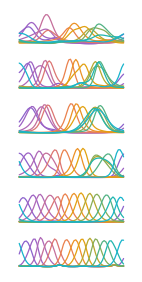

In [4]:
######################################################################
# Timepoints to sample for f4-right
f4r_opts = {**options, 
    'features':'oneatatime',
    'saveall':True,
    'T':50,
    'Δ':50,
    'I':1000
}
# Homeostasis needs a head start since initial activity distribution
# is very different from the distribution after drift
# Use a more aggressive homeostasis for figure 4, right; Since naïve homeostasis
# isn't calibrated to the drift rate, it needs to run faster or longer per day
# if starting from the initially trained state than the other methods.
jobs = [{**f4r_opts,'method':'homeostat' ,'normalize':False,**homeostat_rates},
        {**f4r_opts,'method':'hebbhomeo' ,'normalize':False,**hebb_rates     },
        {**f4r_opts,'method':'hebbhomeo' ,'normalize':True ,**hebb_rates     },
        {**f4r_opts,'method':'recurrent' ,'normalize':True ,**map_rates      },
        {**f4r_opts,'method':'predictive','normalize':True ,**feedback_rates }]
pop_homeostat,pop_hebbhomeo,pop_normalize,pop_recurrent,pop_predictive=_parmap(helper,jobs)

# Simulate fixed readout and collect all results
W0,X,Y,Z,W,R,G,B = pop_recurrent
λ0 = sexp(einsum('km,tkl->tml',W0,X))
λh = array(pop_homeostat [3])
λb = array(pop_hebbhomeo [3])
λc = array(pop_normalize [3])
λr = array(pop_recurrent [3])
λp = array(pop_predictive[3])

# Plot
t = -1
nbump = 13
ix = int32(round(linspace(0,options['M']-1,nbump*2+1)[1:-1:2]))
figure(figsize=(1,2))
λs = [λ0,λh,λb,λc,λr,λp]
nl = len(λs)
for il,λ in enumerate(λs):
    subplot(nl,1,il+1)
    for i in range(nbump):
        plot(linspace(0,1,options['L']),λ[-1,ix[i]],color=riley(.8*i/nbump),lw=.65)
    noxyaxes()
    
tight_layout()
#savefigure('f4-right',stamp=False)